# Heartbeat disease classifier

In [40]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

# Audio
import librosa
import librosa.display

# Plot
import matplotlib.pyplot as plt

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

### Build Dataset

In [76]:
%%time
dataset = []
for folder in ["../input/set_a/**","../input/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

CPU times: user 116 ms, sys: 116 ms, total: 232 ms
Wall time: 706 ms


In [77]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
filename    404 non-null object
label       404 non-null object
dtypes: object(2)
memory usage: 9.5+ KB


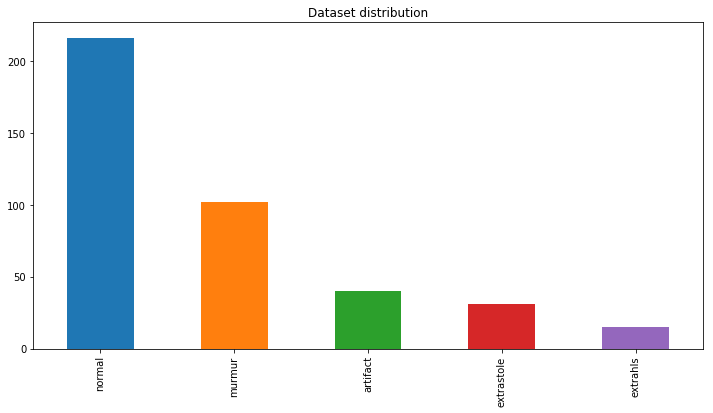

In [78]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

### Split dataset in train and test

In [79]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 363
Test: 41


### Show Audio info

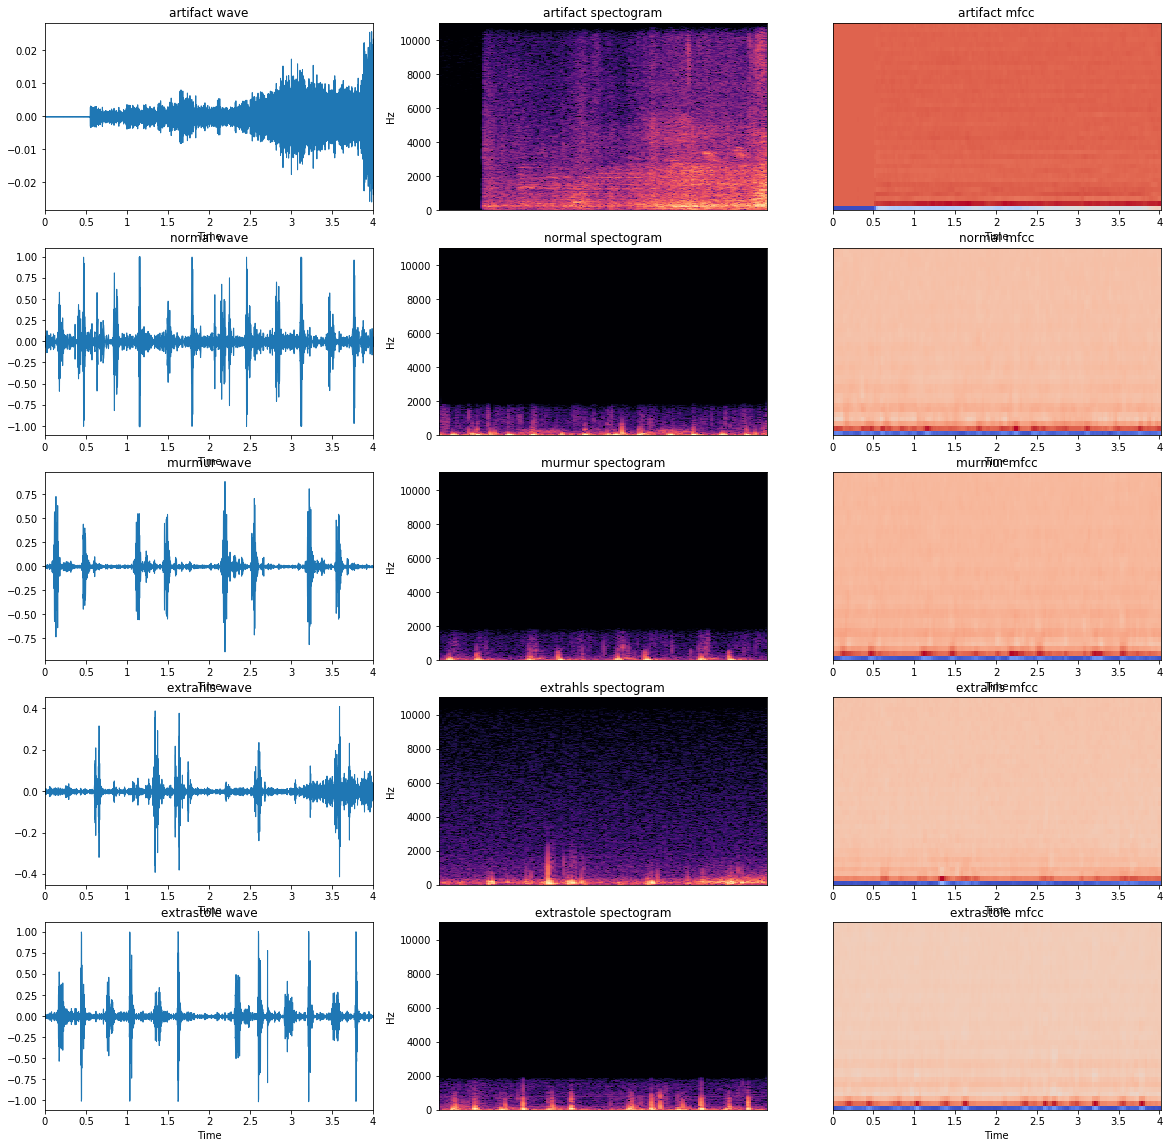

CPU times: user 4.76 s, sys: 1.78 s, total: 6.54 s
Wall time: 4.25 s


In [80]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()


### Extract features from audio

In [81]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [82]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 1/363 [00:00<00:39,  9.17it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 41/41 [00:08<00:00,  4.56it/s]

X train: (363, 40, 173)
X test: (41, 40, 173)
CPU times: user 1min 28s, sys: 34.7 s, total: 2min 3s
Wall time: 1min 17s


### Encode labels

In [83]:
%%time
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 757 µs


### Compute class weights

In [84]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)



### Input shapes

In [85]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (363, 40, 173, 1)
Y train: (363, 5)

X test: (41, 40, 173, 1)
Y test: (41, 5)


### Build Model

In [86]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 41, 64)         8256      
__________

### Compile model

In [87]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Fit model

In [88]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights,
              shuffle=True)

Train on 363 samples, validate on 41 samples
Epoch 1/300
363/363 [==============================] - 1s 3ms/step - loss: 9.6386 - acc: 0.2314 - val_loss: 3.0499 - val_acc: 0.5366
Epoch 2/300
363/363 [==============================] - 0s 132us/step - loss: 5.9964 - acc: 0.4683 - val_loss: 4.2748 - val_acc: 0.1707
Epoch 3/300
363/363 [==============================] - 0s 130us/step - loss: 5.3659 - acc: 0.4656 - val_loss: 2.3563 - val_acc: 0.5366
Epoch 4/300
363/363 [==============================] - 0s 123us/step - loss: 4.8853 - acc: 0.5344 - val_loss: 1.2485 - val_acc: 0.3171
Epoch 5/300
363/363 [==============================] - 0s 115us/step - loss: 4.3086 - acc: 0.4132 - val_loss: 0.8329 - val_acc: 0.7561
Epoch 6/300
363/363 [==============================] - 0s 132us/step - loss: 3.9843 - acc: 0.5207 - val_loss: 0.8636 - val_acc: 0.7317
Epoch 7/300
363/363 [==============================] - 0s 126us/step - loss: 3.6030 - acc: 0.5427 - val_loss: 0.9032 - val_acc: 0.6585
Epoch 8/300


Epoch 61/300
363/363 [==============================] - 0s 126us/step - loss: 0.7915 - acc: 0.6612 - val_loss: 0.8717 - val_acc: 0.7561
Epoch 62/300
363/363 [==============================] - 0s 127us/step - loss: 0.8094 - acc: 0.6832 - val_loss: 0.8685 - val_acc: 0.7317
Epoch 63/300
363/363 [==============================] - 0s 124us/step - loss: 0.7253 - acc: 0.7052 - val_loss: 0.8704 - val_acc: 0.7317
Epoch 64/300
363/363 [==============================] - 0s 127us/step - loss: 0.7582 - acc: 0.6942 - val_loss: 0.8657 - val_acc: 0.7317
Epoch 65/300
363/363 [==============================] - 0s 125us/step - loss: 0.7314 - acc: 0.7300 - val_loss: 0.8504 - val_acc: 0.7805
Epoch 66/300
363/363 [==============================] - 0s 120us/step - loss: 0.7685 - acc: 0.6860 - val_loss: 0.8678 - val_acc: 0.7073
Epoch 67/300
363/363 [==============================] - 0s 122us/step - loss: 0.7575 - acc: 0.6749 - val_loss: 0.8470 - val_acc: 0.7561
Epoch 68/300
363/363 [==========================

363/363 [==============================] - 0s 135us/step - loss: 0.6559 - acc: 0.7135 - val_loss: 0.6918 - val_acc: 0.7561
Epoch 122/300
363/363 [==============================] - 0s 132us/step - loss: 0.6480 - acc: 0.7410 - val_loss: 0.6707 - val_acc: 0.7805
Epoch 123/300
363/363 [==============================] - 0s 128us/step - loss: 0.6662 - acc: 0.7466 - val_loss: 0.6582 - val_acc: 0.7317
Epoch 124/300
363/363 [==============================] - 0s 121us/step - loss: 0.6433 - acc: 0.7355 - val_loss: 0.6662 - val_acc: 0.8049
Epoch 125/300
363/363 [==============================] - 0s 127us/step - loss: 0.6588 - acc: 0.7410 - val_loss: 0.6951 - val_acc: 0.7805
Epoch 126/300
363/363 [==============================] - 0s 123us/step - loss: 0.6395 - acc: 0.7438 - val_loss: 0.6971 - val_acc: 0.7561
Epoch 127/300
363/363 [==============================] - 0s 129us/step - loss: 0.6442 - acc: 0.7328 - val_loss: 0.6563 - val_acc: 0.7561
Epoch 128/300
363/363 [==============================] 

Epoch 181/300
363/363 [==============================] - 0s 125us/step - loss: 0.5736 - acc: 0.7631 - val_loss: 0.6771 - val_acc: 0.8293
Epoch 182/300
363/363 [==============================] - 0s 120us/step - loss: 0.5888 - acc: 0.7631 - val_loss: 0.6357 - val_acc: 0.8293
Epoch 183/300
363/363 [==============================] - 0s 127us/step - loss: 0.5906 - acc: 0.7438 - val_loss: 0.6099 - val_acc: 0.8293
Epoch 184/300
363/363 [==============================] - 0s 140us/step - loss: 0.5697 - acc: 0.7631 - val_loss: 0.5922 - val_acc: 0.8293
Epoch 185/300
363/363 [==============================] - 0s 133us/step - loss: 0.5743 - acc: 0.7548 - val_loss: 0.6242 - val_acc: 0.8049
Epoch 186/300
363/363 [==============================] - 0s 127us/step - loss: 0.5464 - acc: 0.7658 - val_loss: 0.6399 - val_acc: 0.8780
Epoch 187/300
363/363 [==============================] - 0s 127us/step - loss: 0.5605 - acc: 0.7521 - val_loss: 0.6045 - val_acc: 0.8293
Epoch 188/300
363/363 [==================

Epoch 241/300
363/363 [==============================] - 0s 139us/step - loss: 0.5235 - acc: 0.7741 - val_loss: 0.5395 - val_acc: 0.8049
Epoch 242/300
363/363 [==============================] - 0s 141us/step - loss: 0.5239 - acc: 0.7796 - val_loss: 0.5769 - val_acc: 0.8293
Epoch 243/300
363/363 [==============================] - 0s 121us/step - loss: 0.5163 - acc: 0.7824 - val_loss: 0.6269 - val_acc: 0.8537
Epoch 244/300
363/363 [==============================] - 0s 121us/step - loss: 0.5039 - acc: 0.7879 - val_loss: 0.5716 - val_acc: 0.8049
Epoch 245/300
363/363 [==============================] - 0s 124us/step - loss: 0.5046 - acc: 0.7851 - val_loss: 0.5622 - val_acc: 0.8780
Epoch 246/300
363/363 [==============================] - 0s 124us/step - loss: 0.4933 - acc: 0.7824 - val_loss: 0.5827 - val_acc: 0.8780
Epoch 247/300
363/363 [==============================] - 0s 124us/step - loss: 0.4747 - acc: 0.7989 - val_loss: 0.5303 - val_acc: 0.8780
Epoch 248/300
363/363 [==================

CPU times: user 15.8 s, sys: 2.24 s, total: 18 s
Wall time: 15.5 s


Text(0.5, 1.0, 'Accuracy Curves')

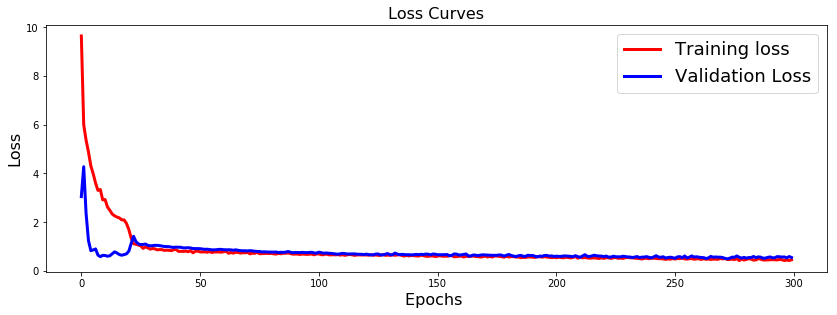

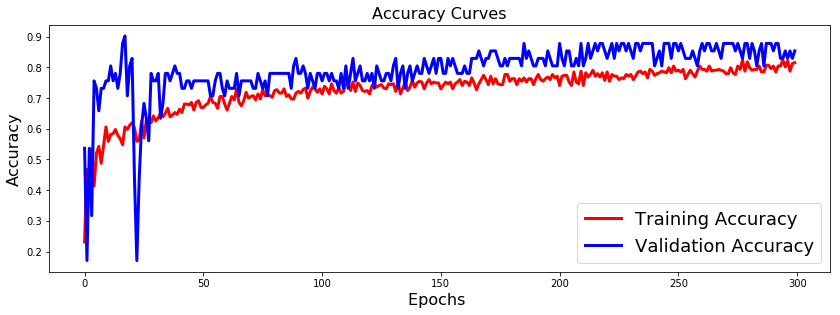

In [89]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Save model

In [90]:
# Save model and weights
model_name = "heartbeat_disease.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at heartbeat_disease.h5 


### Evaluate model

In [91]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

41/41 [==============================] - 0s 399us/step
Test loss: 0.5542245638079759
Test accuracy: 0.8536585365853658


### Classification Report

In [92]:
predictions = model.predict(x_test, verbose=1)

41/41 [==============================] - 0s 4ms/step


In [93]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

In [94]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        11
    extrahls       1.00      0.50      0.67         2
  extrastole       0.00      0.00      0.00         1
      murmur       0.71      0.71      0.71         7
      normal       0.82      0.90      0.86        20

   micro avg       0.85      0.85      0.85        41
   macro avg       0.71      0.62      0.65        41
weighted avg       0.84      0.85      0.84        41



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Confusion Matrix

In [95]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()

    plt.show()

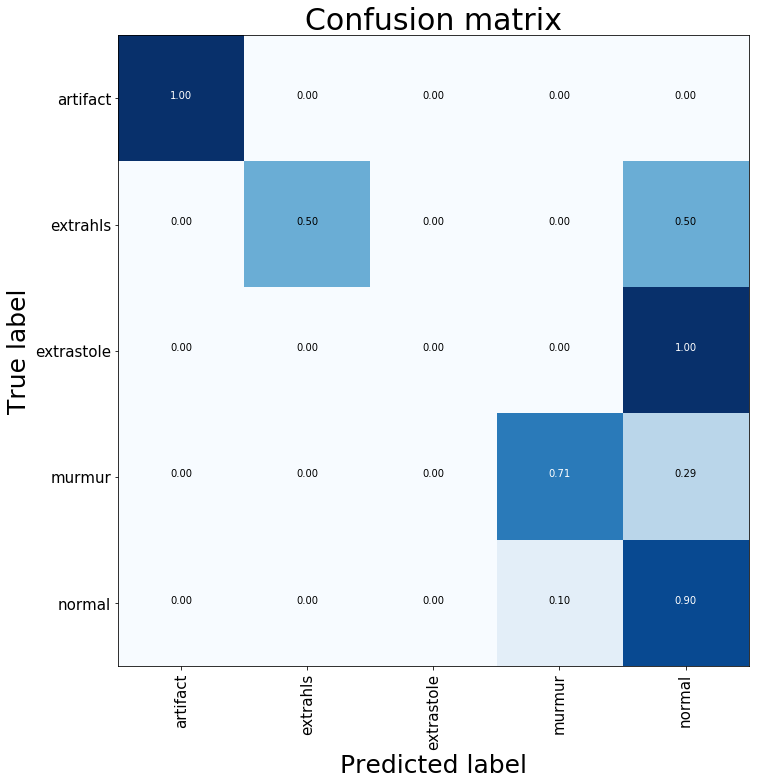

In [96]:
cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes)